## Datasets and DataLoaders

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

PyTorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass torch.utils.data.Dataset and implement functions specific to the particular data. They can be used to prototype and benchmark your model. You can find them here: Image Datasets, Text Datasets, and Audio Datasets

## Loading a Dataset

Here we'll load the Fashion-MNIST dataset from TorchVision. 
        Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training samples and 10,000 test samples. Each example comprises a 28*28 grayscale image and an associated label from one of its 10 classes.

#### We load the FashionMNIST Dataset with the following parameters:* $
roo$t is the path where the train/test data is stored,* TRAIN specifies training or test dataset*
*  DOWNLOADnload=True downloads the data from the internet if it’s not available 
* transformm and target_transform specify the feature and label transformations

## Load torchvision Dataset *"FashionMNIST"*

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [2]:
Dataset

torch.utils.data.dataset.Dataset

In [3]:
datasets

<module 'torchvision.datasets' from 'C:\\Users\\USER\\anaconda3\\Lib\\site-packages\\torchvision\\datasets\\__init__.py'>

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Iterating and Visualizing the Dataset

We can index Datasets manually like a list: training_data[index]. We use matplotlib to visualize some samples in our training data.

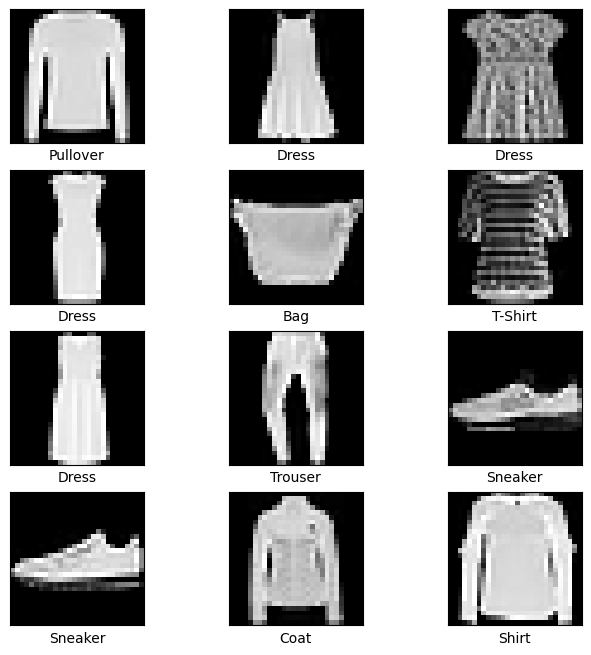

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.xticks([])   #to remove the numbering beisde the axis
    plt.yticks([])   #to remove the numbering beside the axis
    plt.xlabel(labels_map[label])   #assigning labels to each image
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Loading  Custom Dataset

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

## Access and Process Image data for facial recognition 

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.io as io
import torchvision.transforms as transforms
import os
import pandas as pd

#FUNCTION TO ACCESS, PROCESS IMAGE, AND ATTACH LABELS

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        # Read the CSV file without headers
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        # Set default transformations if none are provided
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((128, 128))  # Resize all images to (128, 128)
            
        ])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Extract image name from the first column
        img_name = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name) + ".jpg"

        # Initialize image tensor
        image = torch.zeros((3, 128, 128))  # Default black image

        if not os.path.exists(img_path):
            print(f"WARNING: {img_path} not found! Using a lack image.")
            image = torch.zeros((3, 128, 128))   #Default black image
        else:
            try:
                # Read and normalize the image
                image = io.read_image(img_path).float() / 255.0
                # Apply transformations
                image = self.transform(image)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}. Using a black image.")
                image = torch.zeros((3, 128, 128))
        try:
            label = int(self.img_labels.iloc[idx, 1])    #convert label to int
        except ValueError:
            print(f"Invalid label '{self.img_labels.iloc[idx, 1]}' at index {idx}. Assigning label -1.")
            label = -1
        return image, torch.tensor(label, dtype = torch.long)
        
# Define paths
annotations_file = 'facial_recognition9.csv'
img_dir = r"C:\Users\USER\3D Objects"

# Create dataset
dataset = CustomImageDataset(annotations_file, img_dir)

# Use DataLoader
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

# Debugging: Check first batch
for images, labels in dataloader:
    print(images.shape, labels.shape)  # Expected: (batch_size, 3, 128, 128), (batch_size,)
    break


torch.Size([20, 3, 128, 128]) torch.Size([20])


#### Check if Image Exist

In [8]:

import os

img_path = r"C:\Users\USER\3D Objects\baby03.jpg"
if os.path.exists(img_path):
    print("file exist!")  #Check if image files exist in path
else:
    print(f"Warning: {img_path} not found!")



file exist!


## Define Model Architecture

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNNModel, self).__init__()

        # First Convolutional Layer: Input(3, 128, 128) → Output(32, 128, 128)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output(32, 64, 64)

        # Second Convolutional Layer: Input(32, 64, 64) → Output(64, 64, 64)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output(64, 32, 32)

        # Third Convolutional Layer: Input(64, 32, 32) → Output(128, 32, 32)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output(128, 16, 16)

        # Dropout Layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.5)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # First FC Layer
        self.fc2 = nn.Linear(256, 128)  # Second FC Layer
        self.fc3 = nn.Linear(128, num_classes)  # Third FC Layer (4 output classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool1
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool2
        x = self.pool3(F.relu(self.conv3(x)))  # Conv3 -> ReLU -> Pool3

        # 🔄 Flatten before Fully Connected Layers
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128 * 16 * 16)

        # 🟠 Fully Connected Layers + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, CrossEntropyLoss will handle it
        return x


In [11]:
#initialize the model, Loss Function adn optimizer
num_classes = 4  # Replace with the actual number of classes in your dataset
model = CNNModel(num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [12]:
import torch
import torch.optim as optim
import torch.nn as nn

# Define device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
num_classes = 4
model = CNNModel(num_classes).to(device)

# Define loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam works well for CNNs)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training settings
num_epochs = 20
batch_size = 100

print("Training PyTorch Convolutional Neural Network")
# Loop through dataset
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in dataloader:  
        images, labels = images.to(device), labels.to(device)  # Move data to device

        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        
    # Print loss for each epoch
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

print("Training complete!")


Training PyTorch Convolutional Neural Network
Epoch [1/20], Loss: 1.3862
Epoch [2/20], Loss: 1.4203
Epoch [3/20], Loss: 1.3941
Epoch [4/20], Loss: 1.3724
Epoch [5/20], Loss: 1.3459
Epoch [6/20], Loss: 1.3342
Epoch [7/20], Loss: 1.2920
Epoch [8/20], Loss: 1.2420
Epoch [9/20], Loss: 1.1204
Epoch [10/20], Loss: 1.1275
Epoch [11/20], Loss: 0.9669
Epoch [12/20], Loss: 0.8654
Epoch [13/20], Loss: 0.6994
Epoch [14/20], Loss: 0.6413
Epoch [15/20], Loss: 0.4900
Epoch [16/20], Loss: 0.3913
Epoch [17/20], Loss: 0.3219
Epoch [18/20], Loss: 0.3943
Epoch [19/20], Loss: 0.1864
Epoch [20/20], Loss: 0.0795
Training complete!


## Model Evaluation

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


Accuracy of the model on the test images: 90.00%


In [14]:
# MODEL ARCHITECTURE
model.eval()


CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

## Data Preparation

The "Dataset" retrieves dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

    _DataLoader is an iterable that abstracts this complexity for us in an easy API._

In [15]:
from torch.utils.data import DataLoader 

train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

## Iterate through the DataLoader
We have loaded that dataset into the DataLoader and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing batch_size=64 features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled (for finer-grained control over the data loading order, take a look at Samplers).

 ACTUAL VALUE {'PRESH'} 
 PREDICTED VALUE {'PRESH'}


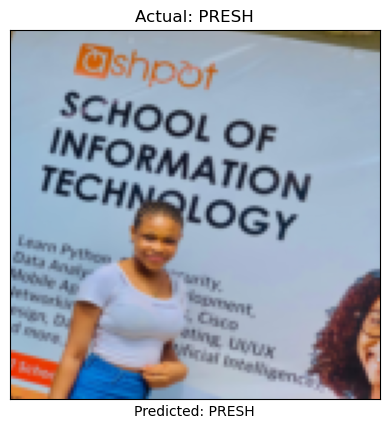

In [16]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

labels_ID = {
    0: "Prince",
    1: "My BABY",
    2: "Smile",
    3: "PRESH"
}



# Get a single batch from the dataloader
images, labels = next(iter(dataloader))

# Select one image
image = images[0].unsqueeze(0)  # Add batch dimension
label = labels[0].item()        #label of image

# Move to the same device as the model
image = image.to(device)

# Set model to evaluation mode
model.eval()

# Make a prediction
with torch.no_grad():
    output = model(image)
    predicted_label = torch.argmax(output, dim=1).item()

# Convert image tensor to a format for visualization
image = image.squeeze(0).cpu().permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)


#code to print the raw texts of predicted values

print(f" ACTUAL VALUE", {labels_ID[label]}, "\n", "PREDICTED VALUE", {labels_ID[predicted_label]})
# Plot the image with the predicted label
plt.imshow(image)
plt.title(f"Actual: {labels_ID[label]}")
plt.xlabel(f"Predicted: {labels_ID[predicted_label]}") 
plt.yticks([])
plt.xticks([])
plt.show()


## Test Model with unseen image

#### Image data preprocessing

In [17]:
# Load the unseen image
test_image_path = r"C:\Users\USER\3D Objects\test_img.jpg"

if os.path.exists(test_image_path):
    print("Image Exist")
else:
    print("Image doesn't exist. retrace computation")

Image Exist


In [18]:
# Define the transform for preprocessing
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])



In [19]:
# Load the unseen image

if os.path.exists(test_image_path):
    # Read image and apply transformation
    test_image = Image.open(test_image_path).convert("RGB")    #To ensure Coloured image format
    test_image_trans = transform(test_image)  # Apply transformations
    test_image = test_image_trans.unsqueeze(0)  # Add batch dimension
    if test_image.dim() == 5:   #check for shape with five dimensions and reshape
        test_image = test_image.squeeze(0)
else:
    raise FileNotFoundError(f"Image {test_image_path} not found!")

print(test_image.shape)

torch.Size([1, 3, 128, 128])


In [20]:
test_image

tensor([[[[ 0.9922,  0.9451,  0.9765,  ...,  0.0667,  0.0902,  0.1059],
          [ 0.9922,  0.9451,  0.9843,  ...,  0.0588,  0.0667,  0.0980],
          [ 1.0000,  0.9608,  0.9922,  ...,  0.3333,  0.5294,  0.6235],
          ...,
          [-0.6471, -0.6471, -0.6471,  ..., -0.0980, -0.1137, -0.1373],
          [-0.7961, -0.7882, -0.7725,  ..., -0.0353, -0.0353, -0.0353],
          [-0.6627, -0.6863, -0.7020,  ..., -0.0353, -0.0353, -0.0275]],

         [[ 0.9922,  0.9059,  0.9608,  ...,  0.3490,  0.3725,  0.3882],
          [ 0.9922,  0.9373,  0.9843,  ...,  0.4980,  0.5451,  0.5686],
          [ 0.9922,  0.9686,  0.9922,  ...,  0.8667,  0.9137,  0.9373],
          ...,
          [-0.6157, -0.6157, -0.6157,  ...,  0.4510,  0.4353,  0.4196],
          [-0.7725, -0.7647, -0.7490,  ...,  0.5529,  0.5529,  0.5451],
          [-0.6314, -0.6549, -0.6706,  ...,  0.5529,  0.5529,  0.5608]],

         [[ 0.9137,  0.5608,  0.7804,  ...,  0.7882,  0.8118,  0.8275],
          [ 0.9451,  0.6078,  

In [21]:
with torch.no_grad():
    output = model(test_image)
    test_predicted_label = torch.argmax(output, dim=1).item()

print(f'PREDICTED CLASS : {test_predicted_label}')

PREDICTED CLASS : 2


## Visualize predicted image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ACTUAL VALUE : PRESH 
 Predicted value: Smile


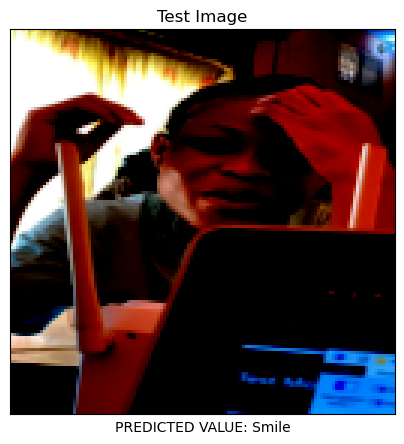

In [22]:
image_np =  test_image_trans.permute(1, 2, 0).numpy()    #convert back to numpy for visualization
print(f"ACTUAL VALUE : {labels_ID[3]} \n Predicted value: {labels_ID[test_predicted_label]}")
# Visualize
plt.figure(figsize=(5, 5))
plt.imshow(image_np)
plt.xticks([])
plt.yticks([])
plt.xlabel(f"PREDICTED VALUE: {labels_ID[test_predicted_label]}")
plt.title("Test Image")
plt.show()